In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss
from imblearn.combine import SMOTEENN

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50V2, InceptionResNetV2, NASNetMobile, MobileNet
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.regularizers import l2
import keras_tuner as kt

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_classes=4

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
pd.set_option('display.max_colwidth', None)

categories = ["adenocarcinoma", "large_cell_carcinoma", "normal", "squamous_cell_carcinoma"]

In [2]:
# TRAIN data

directory_train = r"lung_classification_dataset\train"

adenocarcinoma_dir = directory_train + "/" + categories[0]
large_cell_carcinoma_dir = directory_train + "/" + categories[1]
normal_dir = directory_train + "/" + categories[2]
squamos_cell_carcinoma_dir = directory_train + "/" + categories[3]

path_list_train = []
category_list_train = []
for category in categories:
    folder_path = os.path.join(directory_train, category)
    folder_image_contents = os.listdir(folder_path)
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        path_list_train.append(image_file_path)
        category_list_train.append(category)

path_series_train = pd.Series(path_list_train, name="filepath")
category_series_train = pd.Series(category_list_train, name="category")

image_paths_train_df = pd.DataFrame(path_series_train).join(category_series_train)

#print(image_paths_train_df.head())   

# VAL data
directory_val = r"lung_classification_dataset\valid"

adenocarcinoma_dir = directory_val + "/" + categories[0]
large_cell_carcinoma_dir = directory_val + "/" + categories[1]
normal_dir = directory_val + "/" + categories[2]
squamos_cell_carcinoma_dir = directory_val + "/" + categories[3]

path_list_val = []
category_list_val = []
for category in categories:
    folder_path = os.path.join(directory_val, category)
    folder_image_contents = os.listdir(folder_path)
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        path_list_val.append(image_file_path)
        category_list_val.append(category)

path_series_val = pd.Series(path_list_val, name="filepath")
category_series_val = pd.Series(category_list_val, name="category")

image_paths_val_df = pd.DataFrame(path_series_val).join(category_series_val)

#print(image_paths_val_df.head())

# TEST data
directory_test = r"lung_classification_dataset\test"

adenocarcinoma_dir = directory_test + "/" + categories[0]
large_cell_carcinoma_dir = directory_test + "/" + categories[1]
normal_dir = directory_test + "/" + categories[2]
squamos_cell_carcinoma_dir = directory_test + "/" + categories[3]

path_list_test = []
category_list_test = []
for category in categories:
    folder_path = os.path.join(directory_test, category)
    folder_image_contents = os.listdir(folder_path)
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        path_list_test.append(image_file_path)
        category_list_test.append(category)

path_series_test = pd.Series(path_list_test, name="filepath")
category_series_test = pd.Series(category_list_test, name="category")

image_paths_test_df = pd.DataFrame(path_series_test).join(category_series_test)

#print(image_paths_test_df.head())

# Image Resizing

In [4]:
# TRAIN data
size_data_train = {}
is_grayscale = 0 # enter 0 for color, 1 for grayscale
for category in categories:
    folder_path = os.path.join(directory_train, category)
    folder_image_contents = os.listdir(folder_path)
    image_sizes_in_one_category = {}
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_file_path)
        height, width, channel = img.shape
        if(str(height) + " x " + str(width) in image_sizes_in_one_category):
            image_sizes_in_one_category[str(height) + " x " + str(width)] += 1
        else:
            image_sizes_in_one_category[str(height) + " x " + str(width)] = 1
    #plt.imshow(cv2.imread(image_file_path, is_grayscale))
    #plt.show()
    size_data_train[category] = image_sizes_in_one_category
size_data_train_df = pd.DataFrame(size_data_train)
#print(size_data_train)
#print(size_data_train_df.head(10))

# VAL data
size_data_val = {}
is_grayscale = 0 # enter 0 for color, 1 for grayscale
for category in categories:
    folder_path = os.path.join(directory_val, category)
    folder_image_contents = os.listdir(folder_path)
    image_sizes_in_one_category = {}
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_file_path)
        height, width, channel = img.shape
        if(str(height) + " x " + str(width) in image_sizes_in_one_category):
            image_sizes_in_one_category[str(height) + " x " + str(width)] += 1
        else:
            image_sizes_in_one_category[str(height) + " x " + str(width)] = 1
    #plt.imshow(cv2.imread(image_file_path, is_grayscale))
    #plt.show()
    size_data_val[category] = image_sizes_in_one_category
size_data_val_df = pd.DataFrame(size_data_val)
#print(size_data_val)
#print(size_data_val_df.head(10))

# TEST data
size_data_test = {}
is_grayscale = 0 # enter 0 for color, 1 for grayscale
for category in categories:
    folder_path = os.path.join(directory_test, category)
    folder_image_contents = os.listdir(folder_path)
    image_sizes_in_one_category = {}
    for image_file in folder_image_contents:
        image_file_path = os.path.join(folder_path, image_file)
        img = cv2.imread(image_file_path)
        height, width, channel = img.shape
        if(str(height) + " x " + str(width) in image_sizes_in_one_category):
            image_sizes_in_one_category[str(height) + " x " + str(width)] += 1
        else:
            image_sizes_in_one_category[str(height) + " x " + str(width)] = 1
    #plt.imshow(cv2.imread(image_file_path, is_grayscale))
    #plt.show()
    size_data_test[category] = image_sizes_in_one_category
size_data_test_df = pd.DataFrame(size_data_test)
#print(size_data_test)
#print(size_data_test_df.head(10))

In [5]:
# TRAIN data

dataset_train = []
desired_size = 256
for index, row in image_paths_train_df.iterrows():
    filepath = row["filepath"]
    img = cv2.imread(filepath, is_grayscale)
    img = cv2.resize(img, (desired_size, desired_size))
    label = row["category"]
    dataset_train.append([img, label])
    
random.shuffle(dataset_train)

#print(dataset_train[0][0].shape)
#print(dataset_train[0][1])
#plt.imshow(dataset_train[0][0])
#plt.show()

# VAL data

dataset_val = []
desired_size = 256
for index, row in image_paths_val_df.iterrows():
    filepath = row["filepath"]
    img = cv2.imread(filepath, is_grayscale)
    img = cv2.resize(img, (desired_size, desired_size))
    label = row["category"]
    dataset_val.append([img, label])
    
random.shuffle(dataset_val)

#print(dataset_val[0][0].shape)
#print(dataset_val[0][1])
#plt.imshow(dataset_val[0][0])
#plt.show()

# TEST data

dataset_test = []
desired_size = 256
for index, row in image_paths_test_df.iterrows():
    filepath = row["filepath"]
    img = cv2.imread(filepath, is_grayscale)
    img = cv2.resize(img, (desired_size, desired_size))
    label = row["category"]
    dataset_test.append([img, label])
    
random.shuffle(dataset_test)

#print(dataset_test[0][0].shape)
#print(dataset_test[0][1])
#plt.imshow(dataset_test[0][0])
#plt.show()

# Image smoothing

In [7]:
# using bilateral filtering
diameter = 3
sigma_color = 25
sigma_space = 25

# TRAIN data
for data in dataset_train:
    img = cv2.bilateralFilter(data[0], diameter, sigma_color, sigma_space)
    data[0] = img

#plt.imshow(dataset_train[0][0])
#plt.show()

# VAL data
for data in dataset_val:
    img = cv2.bilateralFilter(data[0], diameter, sigma_color, sigma_space)
    data[0] = img

#plt.imshow(dataset_val[0][0])
#plt.show()

# TEST data
for data in dataset_test:
    img = cv2.bilateralFilter(data[0], diameter, sigma_color, sigma_space)
    data[0] = img

#plt.imshow(dataset_test[0][0])
#plt.show()

# Data normalization

In [9]:
# using min-max scaling

# TRAIN data
for data in dataset_train:
    img = data[0]/255.0
    data[0] = img

#plt.imshow(dataset_train[0][0])
#plt.show()

# VAL data
for data in dataset_val:
    img = data[0]/255.0
    data[0] = img

#plt.imshow(dataset_val[0][0])
#plt.show()

# TEST data
for data in dataset_test:
    img = data[0]/255.0
    data[0] = img

#plt.imshow(dataset_test[0][0])
#plt.show()

# Data splitting

In [11]:
x_train, y_train = [], []
x_val, y_val = [], []
x_test, y_test = [], []

for image, category in dataset_train:
    x_train.append(image)
    y_train.append(category)

for image, category in dataset_val:
    x_val.append(image)
    y_val.append(category)

for image, category in dataset_test:
    x_test.append(image)
    y_test.append(category)


x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# apply one-hot encoding

y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

y_test_labels = np.argmax(y_test, axis=1)

for i in range(0, len(label_encoder.classes_)):
    print(i, end="")
    print(" = ", end="")
    print(label_encoder.classes_[i])

0 = adenocarcinoma
1 = large_cell_carcinoma
2 = normal
3 = squamous_cell_carcinoma


# Handling data imbalance

In [13]:
# using SMOTE (like example)
print(x_train.shape)
number_of_samples = x_train.shape[0]
x_train = x_train.reshape(number_of_samples, -1)
print(x_train.shape)

print("before: ", Counter(y_train))

sample_nums = max(Counter(y_train).values()) * 4 - 180
sampling_strategy = {1: sample_nums, 2: sample_nums, 0: sample_nums, 3: sample_nums}

x_train_smt, y_train_smt = SMOTE(sampling_strategy=sampling_strategy, random_state=42).fit_resample(x_train, y_train)

print("after: ", Counter(y_train_smt))
x_train = x_train.reshape(number_of_samples, desired_size, desired_size, 1)
x_train_smt = x_train_smt.reshape(x_train_smt.shape[0], desired_size, desired_size, 1)
print(x_train.shape)
print(x_train_smt.shape)

y_train_smt = to_categorical(y_train_smt, num_classes=num_classes)

x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_val = np.repeat(x_val, 3, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)

(613, 256, 256)
(613, 65536)
before:  Counter({0: 195, 3: 155, 2: 148, 1: 115})
after:  Counter({1: 600, 0: 600, 2: 600, 3: 600})
(613, 256, 256, 1)
(2400, 256, 256, 1)


In [14]:
import psutil
print(f"Available Memory: {psutil.virtual_memory().available / 1e9:.2f} GB")


Available Memory: 3.58 GB


# Data Models

In [16]:
def all_evaluation(y_test_labels, y_pred_labels, model, epoch_num, batch, is_tuning=False):
    output_path = 'output2\\' + model + '_epoch' + str(epoch_num) + '_batch' + str(batch)
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    # Accuracy, precision, recall, f1 score
    print(metrics.classification_report(y_test_labels, y_pred_labels, digits=4))
    report = metrics.classification_report(y_test_labels, y_pred_labels, digits=4)
    cm = metrics.confusion_matrix(y_test_labels, y_pred_labels)
    
    print(f"The Cohen's Kappa Score is: {metrics.cohen_kappa_score(y_test_labels, y_pred_labels)}")
    cohen = metrics.cohen_kappa_score(y_test_labels, y_pred_labels)
    with open(output_path + '\\evaluation_report.txt', 'w') as f:
        f.write(report)
        f.write('\n')
        f.write('The Cohen\'s Kappa Score is: ' + str(cohen))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Adenocarcinoma', 'Large_cell_carcinoma', 'normal', 'squamous_cell_carcinoma'],
                yticklabels=['Adenocarcinoma', 'Large_cell_carcinoma', 'normal', 'squamous_cell_carcinoma'])
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.savefig(output_path + '\\confusion_matrix.jpg')
    plt.show()

### Using CNN

In [ ]:
%%time

model_name = 'cnn'
epoch_num = 30
batch = 16

# cnn model
def build_model_cnn(optimizer="adam", dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation="relu", input_shape=(x_train_smt.shape[1:])))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=["accuracy"])
    return model

model_cnn = build_model_cnn()
model_cnn.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_cnn = model_cnn.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_cnn.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_cnn.history['loss'], color='silver', label='loss')
plt.plot(history_cnn.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_cnn.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using ResNet50V2

In [ ]:
%%time
model_name = 'resnet50v2'
epoch_num = 30
batch = 32

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

def build_model_ResNet50V2():
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_resnet50v2 = build_model_ResNet50V2()
model_resnet50v2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_resnet50v2 = model_resnet50v2.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_resnet50v2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_resnet50v2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_resnet50v2.history['loss'], color='silver', label='loss')
plt.plot(history_resnet50v2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_resnet50v2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### using NasNetMobile

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_2[0][

 Total params: 5,360,280 (20.45 MB)

 Trainable params: 1,088,868 (4.15 MB)

 Non-trainable params: 4,271,412 (16.29 MB)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 513ms/step - accuracy: 0.6614 - loss: 1.0047 - val_accuracy: 0.5694 - val_loss: 1.3360 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 408ms/step - accuracy: 0.8629 - loss: 0.3794 - val_accuracy: 0.6111 - val_loss: 1.1085 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 399ms/step - accuracy: 0.8873 - loss: 0.2947 - val_accuracy: 0.6250 - val_loss: 1.2971 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 391ms/step - accuracy: 0.9114 - loss: 0.2363 - val_accuracy: 0.7500 - val_loss: 0.9050 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 394ms/step - accuracy: 0.9221 - loss: 0.2021 - val_accuracy: 0.7083 - val_loss: 1.0322 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 398ms/step - accuracy: 0.9382 - loss: 0.1869 - val_accuracy: 0.7778 - val_loss: 0.7773 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 30s 400ms/step - accuracy: 0.9496 - loss: 0.

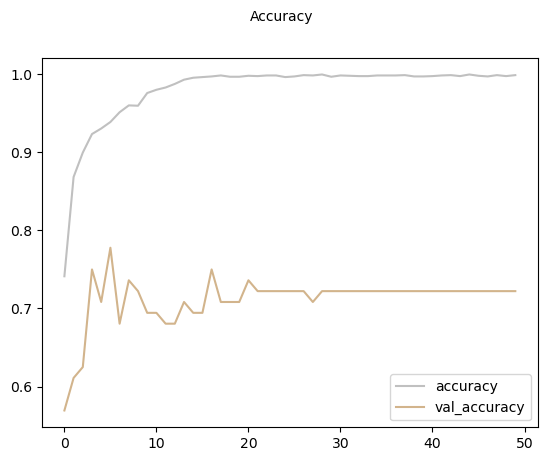

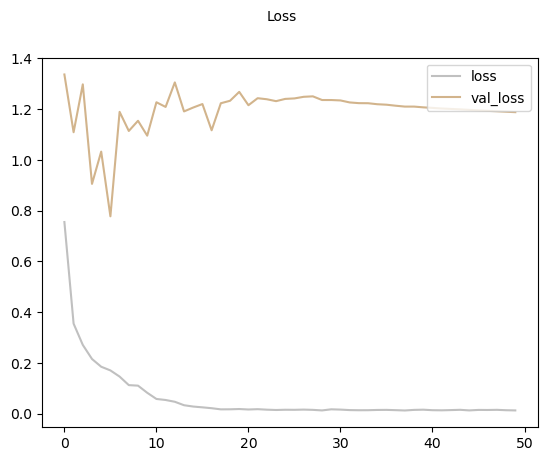

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step 
              precision    recall  f1-score   support

           0     0.6294    0.7500    0.6844       120
           1     0.6000    0.6471    0.6226        51
           2     0.9464    0.9815    0.9636        54
           3     0.6721    0.4556    0.5430        90

    accuracy                         0.6889       315
   macro avg     0.7120    0.7085    0.7034       315
weighted avg     0.6912    0.6889    0.6819       315

The Cohen's Kappa Score is: 0.5636502417097786


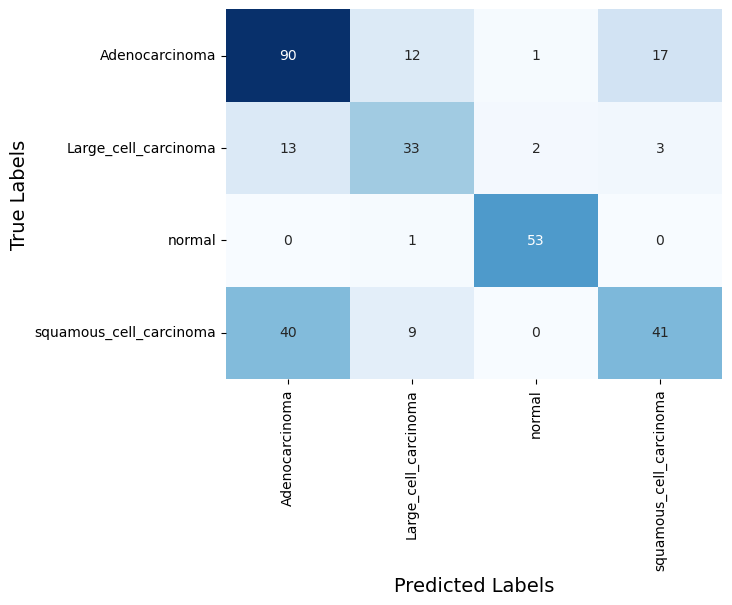

CPU times: total: 1h 44min 17s
Wall time: 26min 23s


In [25]:
%%time

model_name = 'nasnetmobile'
epoch_num = 50
batch = 32

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_nasnetmobile():
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_nasnetmobile = build_model_nasnetmobile()
model_nasnetmobile.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_nasnetmobile = model_nasnetmobile.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_nasnetmobile.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_nasnetmobile.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_nasnetmobile.history['loss'], color='silver', label='loss')
plt.plot(history_nasnetmobile.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_nasnetmobile.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### Using MobileNet

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,577,924 (13.65 MB)

 Trainable params: 2,050,372 (7.82 MB)

 Non-trainable params: 1,527,552 (5.83 MB)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 437ms/step - accuracy: 0.7334 - loss: 0.9536 - val_accuracy: 0.2222 - val_loss: 10.0953 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 409ms/step - accuracy: 0.9687 - loss: 0.0932 - val_accuracy: 0.3194 - val_loss: 11.4021 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 475ms/step - accuracy: 0.9862 - loss: 0.0371 - val_accuracy: 0.4167 - val_loss: 8.1433 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 445ms/step - accuracy: 0.9929 - loss: 0.0262 - val_accuracy: 0.4722 - val_loss: 7.1686 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 442ms/step - accuracy: 0.9952 - loss: 0.0232 - val_accuracy: 0.4028 - val_loss: 11.1459 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 452ms/step - accuracy: 0.9935 - loss: 0.0216 - val_accuracy: 0.5833 - val_loss: 5.6865 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 488ms/step - accuracy: 0.9987 - loss:

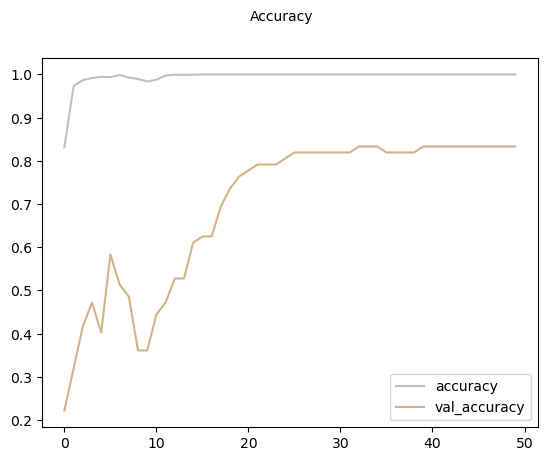

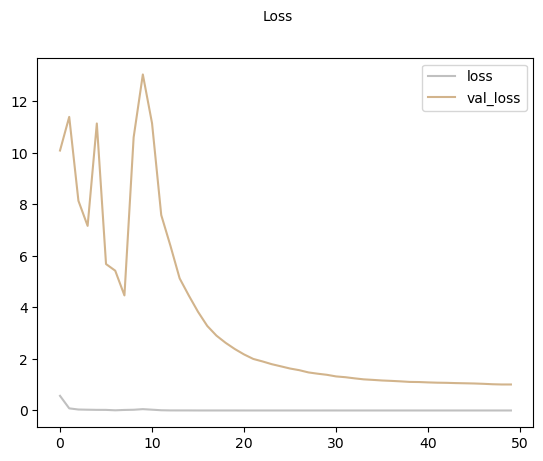

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 556ms/step
              precision    recall  f1-score   support

           0     0.7920    0.8250    0.8082       120
           1     0.8776    0.8431    0.8600        51
           2     1.0000    0.9259    0.9615        54
           3     0.7912    0.8000    0.7956        90

    accuracy                         0.8381       315
   macro avg     0.8652    0.8485    0.8563       315
weighted avg     0.8413    0.8381    0.8393       315

The Cohen's Kappa Score is: 0.7732085380315094


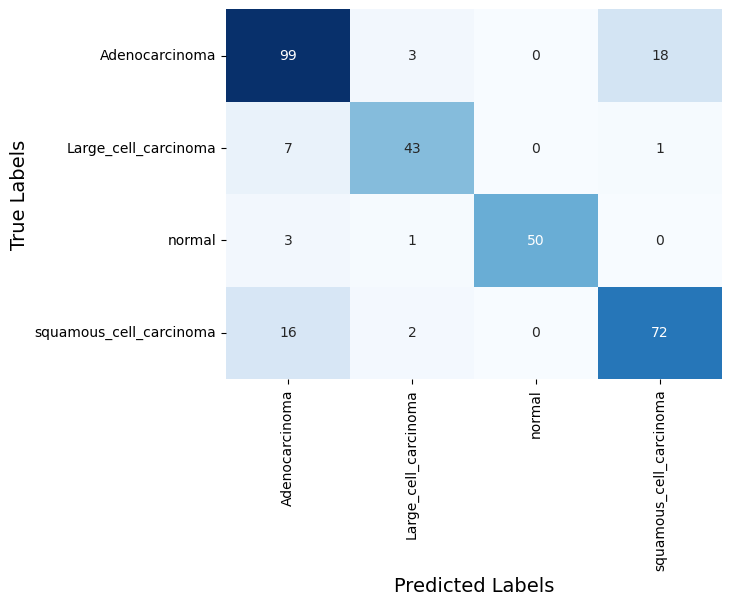

CPU times: total: 34min 57s
Wall time: 29min 53s


In [27]:
%%time
from tensorflow.keras.applications import MobileNetV2

model_name = 'mobilenetv2'
epoch_num = 50
batch = 32

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_mobilenetv2():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_mobilenetv2 = build_model_mobilenetv2()
model_mobilenetv2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_mobilenetv2 = model_mobilenetv2.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_mobilenetv2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_mobilenetv2.history['loss'], color='silver', label='loss')
plt.plot(history_mobilenetv2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_mobilenetv2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### EfficientNetV2 variations

#### EfficientNetV2B0

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer_2[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_project_co… │ (None, None,      │      4,096 │ block2b_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_project_bn  │ (None, None,      │        128 │ block2b_project_

 Total params: 7,239,252 (27.62 MB)

 Trainable params: 1,899,572 (7.25 MB)

 Non-trainable params: 5,339,680 (20.37 MB)

Epoch 1/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.6776 - loss: 1.1841 - val_accuracy: 0.7361 - val_loss: 0.5972 - learning_rate: 0.0010
Epoch 2/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.9113 - loss: 0.2936 - val_accuracy: 0.7500 - val_loss: 0.7629 - learning_rate: 0.0010
Epoch 3/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9239 - loss: 0.2129 - val_accuracy: 0.8333 - val_loss: 0.5340 - learning_rate: 0.0010
Epoch 4/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9408 - loss: 0.1742 - val_accuracy: 0.8056 - val_loss: 0.8716 - learning_rate: 0.0010
Epoch 5/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9533 - loss: 0.1366 - val_accuracy: 0.8750 - val_loss: 0.6277 - learning_rate: 0.0010
Epoch 6/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9691 - loss: 0.0806 - val_accuracy: 0.6944 - val_loss: 1.7098 - learning_rate: 0.0010
Epoch 7/60
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - accuracy: 0.9

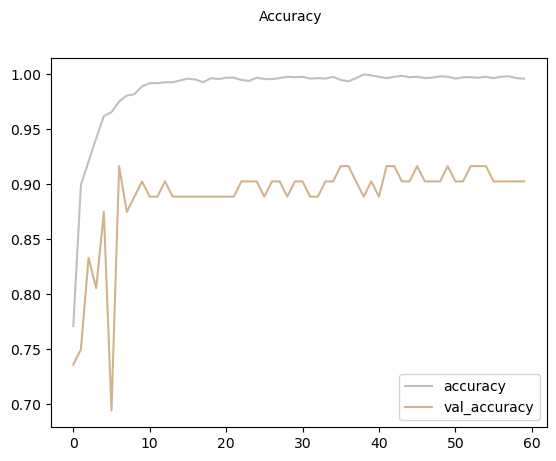

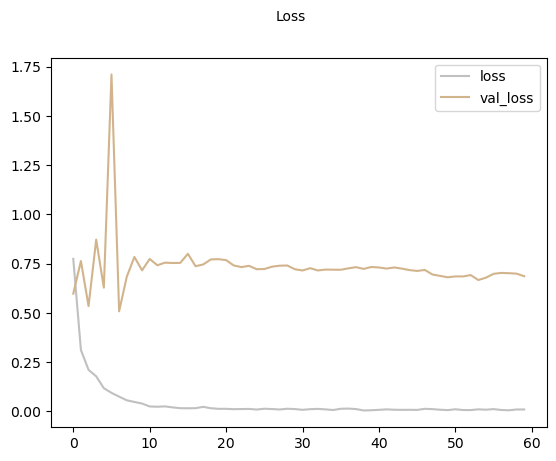

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step
              precision    recall  f1-score   support

           0     0.9684    0.7667    0.8558       120
           1     0.7500    1.0000    0.8571        51
           2     1.0000    0.9815    0.9907        54
           3     0.8182    0.9000    0.8571        90

    accuracy                         0.8794       315
   macro avg     0.8842    0.9120    0.8902       315
weighted avg     0.8955    0.8794    0.8795       315

The Cohen's Kappa Score is: 0.8350898946063237


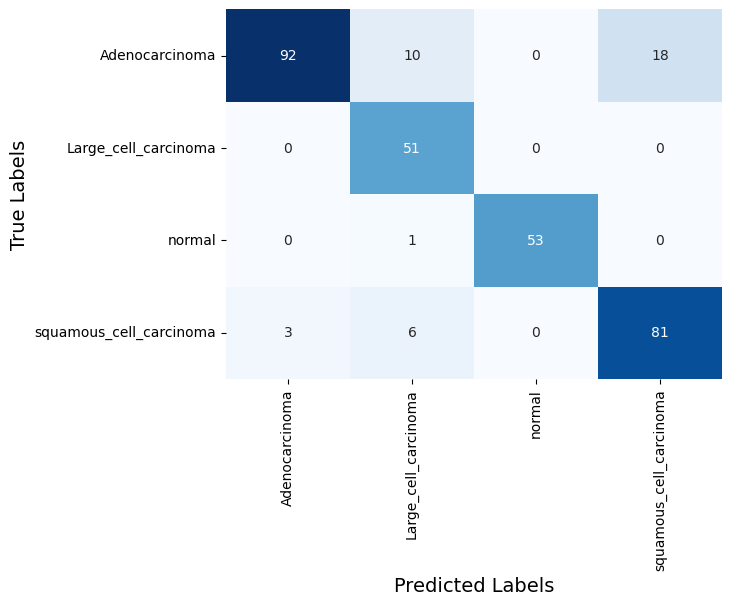

CPU times: total: 14min 52s
Wall time: 21min 41s


In [31]:
%%time

from tensorflow.keras.applications import EfficientNetV2B0

model_name = 'EfficientNetV2B0'
epoch_num = 60
batch = 16

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()


def build_model_EfficientNetV2B0():
    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B0 = build_model_EfficientNetV2B0()
model_EfficientNetV2B0.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

history_EfficientNetV2B0 = model_EfficientNetV2B0.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B0.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B0.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B0.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B0.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B0.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### EfficientNetV2B1

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer_9[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      2,304 │ block1a_project_… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 16)         │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_

 Total params: 8,251,064 (31.48 MB)

 Trainable params: 1,899,572 (7.25 MB)

 Non-trainable params: 6,351,492 (24.23 MB)

Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 185ms/step - accuracy: 0.6488 - loss: 1.3486 - val_accuracy: 0.6944 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 183ms/step - accuracy: 0.8743 - loss: 0.3883 - val_accuracy: 0.7500 - val_loss: 0.7975 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.9086 - loss: 0.2817 - val_accuracy: 0.7778 - val_loss: 0.9691 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 186ms/step - accuracy: 0.9370 - loss: 0.1910 - val_accuracy: 0.8056 - val_loss: 0.6440 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - accuracy: 0.9218 - loss: 0.2410 - val_accuracy: 0.8333 - val_loss: 0.6169 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.9444 - loss: 0.1532 - val_accuracy: 0.8472 - val_loss: 0.6094 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.9

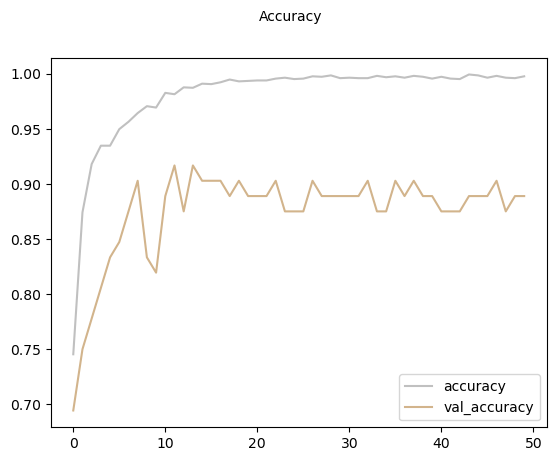

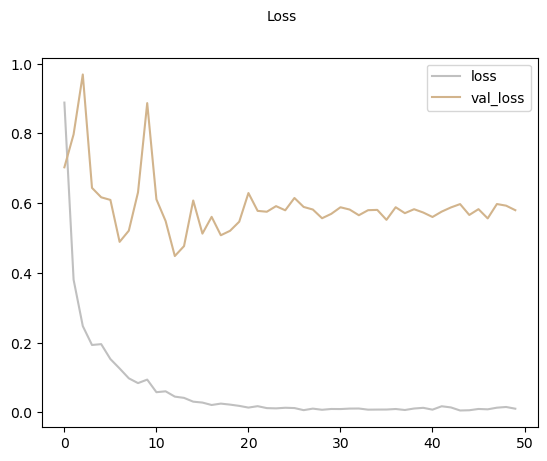

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 441ms/step
              precision    recall  f1-score   support

           0     1.0000    0.5833    0.7368       120
           1     0.7846    1.0000    0.8793        51
           2     0.9815    0.9815    0.9815        54
           3     0.7063    0.9889    0.8241        90

    accuracy                         0.8349       315
   macro avg     0.8681    0.8884    0.8554       315
weighted avg     0.8781    0.8349    0.8268       315

The Cohen's Kappa Score is: 0.7763944631009911


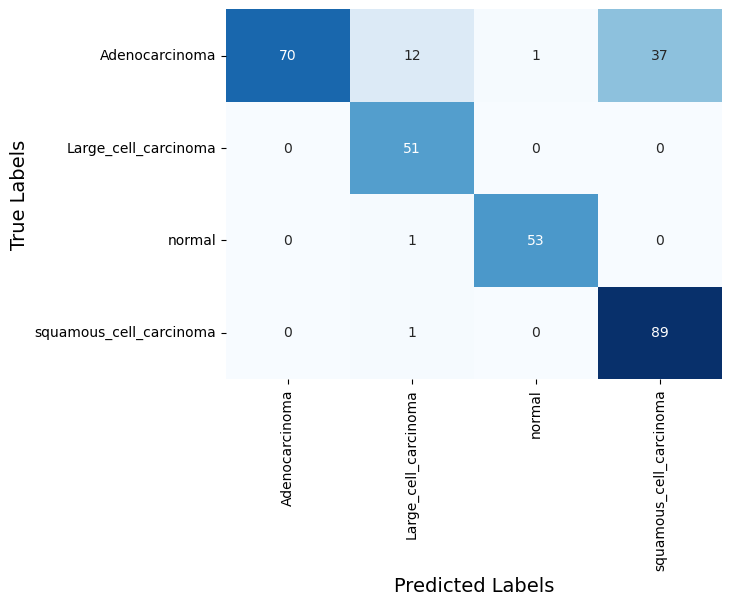

CPU times: total: 13min
Wall time: 23min 44s


In [49]:
%%time

from tensorflow.keras.applications import EfficientNetV2B1

model_name = 'EfficientNetV2B1'
epoch_num = 50
batch = 16

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()

def build_model_EfficientNetV2B1():
    base_model = EfficientNetV2B1(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B1 = build_model_EfficientNetV2B1()
model_EfficientNetV2B1.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8)

history_EfficientNetV2B1 = model_EfficientNetV2B1.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B1.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B1.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B1.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B1.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B1.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### EfficientNetV2B2

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ input_layer_10[0… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      2,304 │ block1a_project_… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 16)         │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_

 Total params: 10,220,386 (38.99 MB)

 Trainable params: 2,135,736 (8.15 MB)

 Non-trainable params: 8,084,650 (30.84 MB)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 402ms/step - accuracy: 0.6370 - loss: 1.2934 - val_accuracy: 0.7083 - val_loss: 0.7056 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - accuracy: 0.8643 - loss: 0.3981 - val_accuracy: 0.7639 - val_loss: 0.6459 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 392ms/step - accuracy: 0.9141 - loss: 0.2199 - val_accuracy: 0.7778 - val_loss: 0.5517 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 29s 393ms/step - accuracy: 0.9334 - loss: 0.1776 - val_accuracy: 0.8889 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 408ms/step - accuracy: 0.9543 - loss: 0.1313 - val_accuracy: 0.8889 - val_loss: 0.4337 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 406ms/step - accuracy: 0.9480 - loss: 0.1362 - val_accuracy: 0.8472 - val_loss: 0.4976 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 425ms/step - accuracy: 0.9647 - loss: 0.

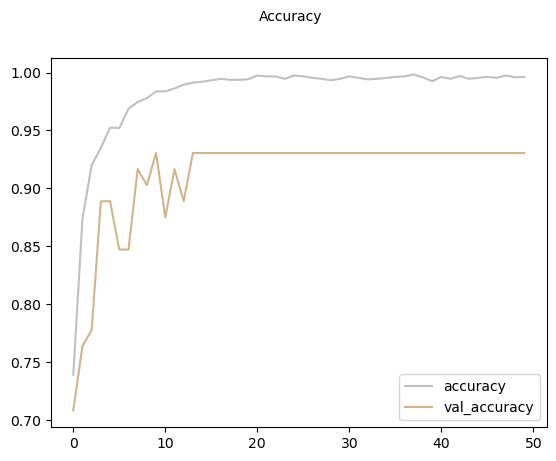

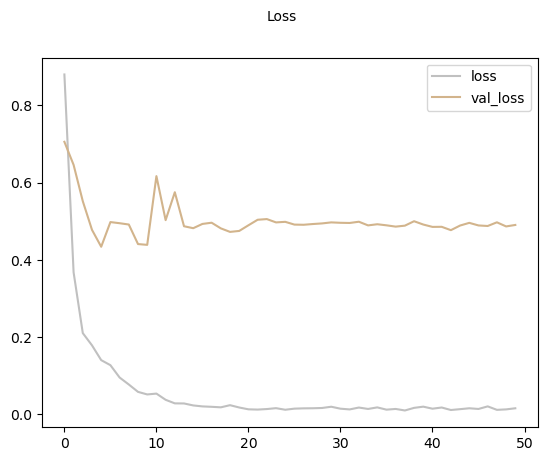

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 530ms/step
              precision    recall  f1-score   support

           0     1.0000    0.6333    0.7755       120
           1     0.6296    1.0000    0.7727        51
           2     1.0000    0.9815    0.9907        54
           3     0.8190    0.9556    0.8821        90

    accuracy                         0.8444       315
   macro avg     0.8622    0.8926    0.8552       315
weighted avg     0.8883    0.8444    0.8424       315

The Cohen's Kappa Score is: 0.7904618392115338


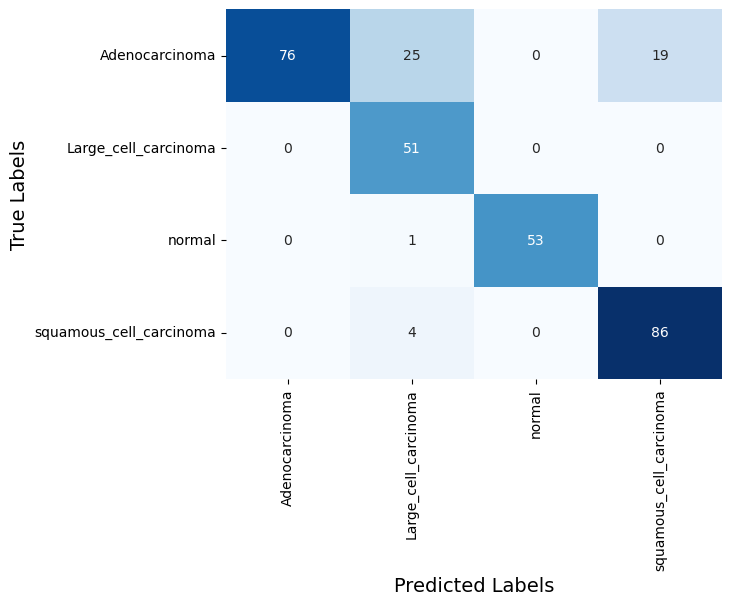

CPU times: total: 17min 30s
Wall time: 24min 22s


In [50]:
%%time

from tensorflow.keras.applications import EfficientNetV2B2

model_name = 'EfficientNetV2B2'
epoch_num = 50
batch = 32

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()

def build_model_EfficientNetV2B2():
    base_model = EfficientNetV2B2(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B2 = build_model_EfficientNetV2B2()
model_EfficientNetV2B2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8)

history_EfficientNetV2B2 = model_EfficientNetV2B2.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B2.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### EfficientNetV2B3

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │      1,080 │ input_layer_11[0… │
│                     │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      5,760 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      2,304 │ block1a_project_… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 16)         │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,560 │ block2a_expand_a… │
│ (Conv2D)            │ None, 40)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        160 │ block2a_project_

 Total params: 14,512,706 (55.36 MB)

 Trainable params: 2,425,790 (9.25 MB)

 Non-trainable params: 12,086,916 (46.11 MB)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 513ms/step - accuracy: 0.6378 - loss: 1.2437 - val_accuracy: 0.7500 - val_loss: 0.6555 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 512ms/step - accuracy: 0.8670 - loss: 0.3849 - val_accuracy: 0.7917 - val_loss: 0.5681 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 507ms/step - accuracy: 0.9018 - loss: 0.2625 - val_accuracy: 0.8472 - val_loss: 0.5290 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 513ms/step - accuracy: 0.9318 - loss: 0.2122 - val_accuracy: 0.8333 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 533ms/step - accuracy: 0.9398 - loss: 0.1563 - val_accuracy: 0.8333 - val_loss: 0.9579 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 539ms/step - accuracy: 0.9521 - loss: 0.1410 - val_accuracy: 0.8750 - val_loss: 0.5121 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 534ms/step - accuracy: 0.9623 - loss: 0.

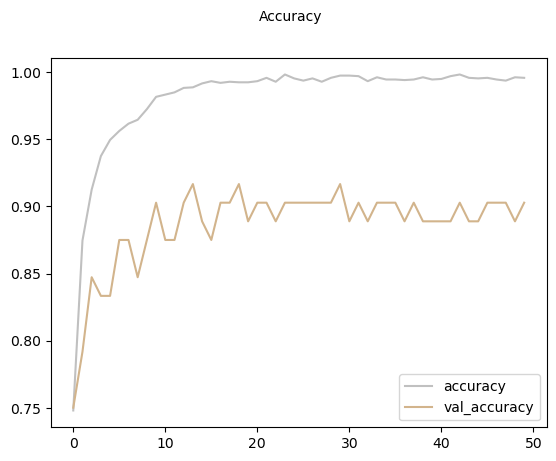

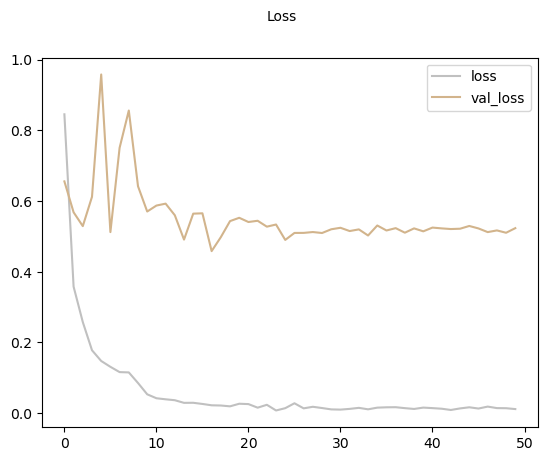

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 607ms/step
              precision    recall  f1-score   support

           0     0.9783    0.7500    0.8491       120
           1     0.7612    1.0000    0.8644        51
           2     1.0000    0.9815    0.9907        54
           3     0.8447    0.9667    0.9016        90

    accuracy                         0.8921       315
   macro avg     0.8960    0.9245    0.9014       315
weighted avg     0.9087    0.8921    0.8908       315

The Cohen's Kappa Score is: 0.8525524533289278


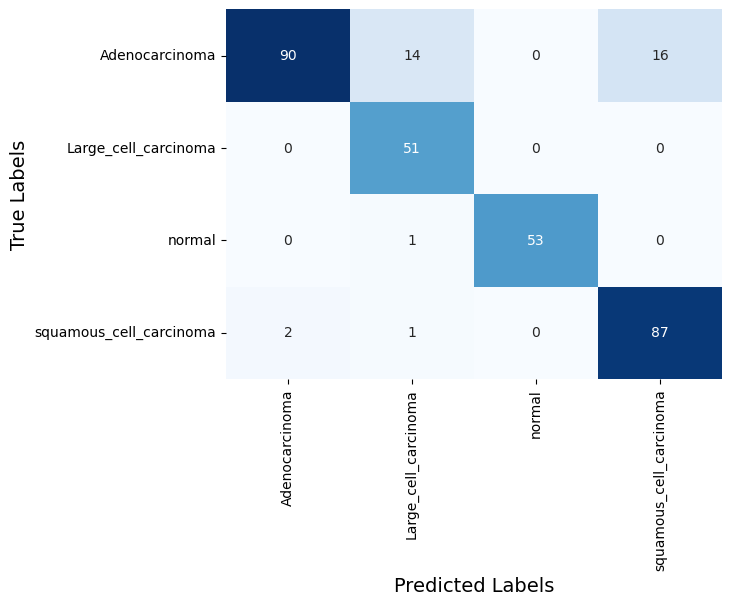

CPU times: total: 23min 18s
Wall time: 32min 48s


In [51]:
%%time

from tensorflow.keras.applications import EfficientNetV2B3

model_name = 'EfficientNetV2B3'
epoch_num = 50
batch = 32

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (255, 255)).numpy()
x_val = tf.image.resize(x_val, (255, 255)).numpy()
x_test = tf.image.resize(x_test, (255, 255)).numpy()

def build_model_EfficientNetV2B3():
    base_model = EfficientNetV2B3(weights='imagenet', include_top=False, include_preprocessing=False)
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_EfficientNetV2B3 = build_model_EfficientNetV2B3()
model_EfficientNetV2B3.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8)

history_EfficientNetV2B3 = model_EfficientNetV2B3.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_EfficientNetV2B3.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_EfficientNetV2B3.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_EfficientNetV2B3.history['loss'], color='silver', label='loss')
plt.plot(history_EfficientNetV2B3.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_EfficientNetV2B3.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### DenseNet variations

#### DenseNet 121

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_12[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,095,300 (30.88 MB)

 Trainable params: 1,223,876 (4.67 MB)

 Non-trainable params: 6,871,424 (26.21 MB)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 593ms/step - accuracy: 0.7241 - loss: 0.7932 - val_accuracy: 0.6806 - val_loss: 0.9548 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 571ms/step - accuracy: 0.9681 - loss: 0.0966 - val_accuracy: 0.7639 - val_loss: 0.8192 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 577ms/step - accuracy: 0.9906 - loss: 0.0307 - val_accuracy: 0.8194 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 599ms/step - accuracy: 0.9898 - loss: 0.0373 - val_accuracy: 0.8333 - val_loss: 0.8670 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 577ms/step - accuracy: 0.9937 - loss: 0.0140 - val_accuracy: 0.8611 - val_loss: 0.8544 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 577ms/step - accuracy: 0.9969 - loss: 0.0132 - val_accuracy: 0.8056 - val_loss: 1.3585 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 575ms/step - accuracy: 0.9990 - loss: 0.

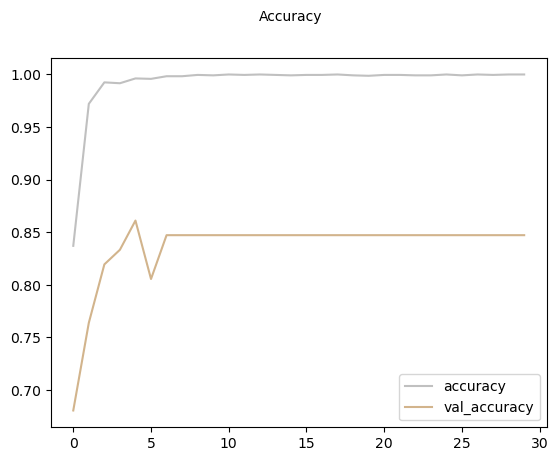

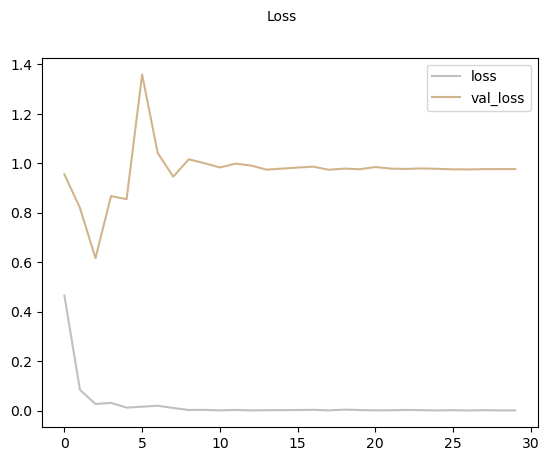

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 754ms/step
              precision    recall  f1-score   support

           0     0.9775    0.7250    0.8325       120
           1     0.6623    1.0000    0.7969        51
           2     1.0000    0.9815    0.9907        54
           3     0.8854    0.9444    0.9140        90

    accuracy                         0.8762       315
   macro avg     0.8813    0.9127    0.8835       315
weighted avg     0.9040    0.8762    0.8771       315

The Cohen's Kappa Score is: 0.8319793205317578


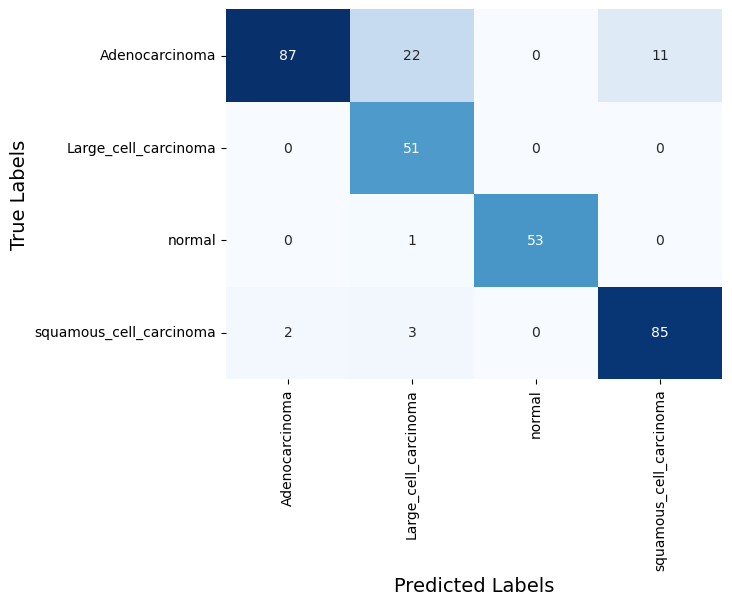

CPU times: total: 17min 5s
Wall time: 22min 22s


In [58]:
%%time
from tensorflow.keras.applications import DenseNet121

model_name = 'densenet121'
epoch_num = 30
batch = 32

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_DenseNet121():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_DenseNet121 = build_model_DenseNet121()
model_DenseNet121.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_DenseNet121 = model_DenseNet121.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_DenseNet121.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_DenseNet121.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_DenseNet121.history['loss'], color='silver', label='loss')
plt.plot(history_DenseNet121.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_DenseNet121.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

#### DenseNet 169

In [60]:
%%time

model_name = 'densenet169'
epoch_num = 30
batch = 32

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_DenseNet169():
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_DenseNet169 = build_model_DenseNet169()
model_DenseNet169.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_DenseNet169 = model_DenseNet169.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_DenseNet169.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_DenseNet169.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_DenseNet169.history['loss'], color='silver', label='loss')
plt.plot(history_DenseNet169.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_DenseNet169.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_13[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 14,356,036 (54.76 MB)

 Trainable params: 1,963,716 (7.49 MB)

 Non-trainable params: 12,392,320 (47.27 MB)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 747ms/step - accuracy: 0.7335 - loss: 0.8471 - val_accuracy: 0.7361 - val_loss: 0.7832 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 712ms/step - accuracy: 0.9628 - loss: 0.1184 - val_accuracy: 0.8611 - val_loss: 0.7055 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 720ms/step - accuracy: 0.9923 - loss: 0.0330 - val_accuracy: 0.8194 - val_loss: 0.6563 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 707ms/step - accuracy: 0.9951 - loss: 0.0225 - val_accuracy: 0.8889 - val_loss: 0.8246 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 707ms/step - accuracy: 0.9979 - loss: 0.0138 - val_accuracy: 0.8889 - val_loss: 0.9558 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 718ms/step - accuracy: 0.9988 - loss: 0.0125 - val_accuracy: 0.8750 - val_loss: 0.7302 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 725ms/step - accuracy: 0.9979 - loss: 0.

KeyboardInterrupt: 

#### DenseNet 201

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 230, 230,  │          0 │ input_layer_14[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 20,297,284 (77.43 MB)

 Trainable params: 2,259,652 (8.62 MB)

 Non-trainable params: 18,037,632 (68.81 MB)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 961ms/step - accuracy: 0.7691 - loss: 0.7567 - val_accuracy: 0.4861 - val_loss: 1.9830 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 910ms/step - accuracy: 0.9665 - loss: 0.0971 - val_accuracy: 0.7917 - val_loss: 0.7058 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 909ms/step - accuracy: 0.9895 - loss: 0.0309 - val_accuracy: 0.7778 - val_loss: 0.8021 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 908ms/step - accuracy: 0.9949 - loss: 0.0251 - val_accuracy: 0.8194 - val_loss: 0.5601 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 69s 922ms/step - accuracy: 0.9970 - loss: 0.0124 - val_accuracy: 0.8889 - val_loss: 0.4431 - learning_rate: 0.0010
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 892ms/step - accuracy: 0.9979 - loss: 0.0121 - val_accuracy: 0.8611 - val_loss: 0.7331 - learning_rate: 0.0010
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 900ms/step - accuracy: 0.9983 - loss: 0.

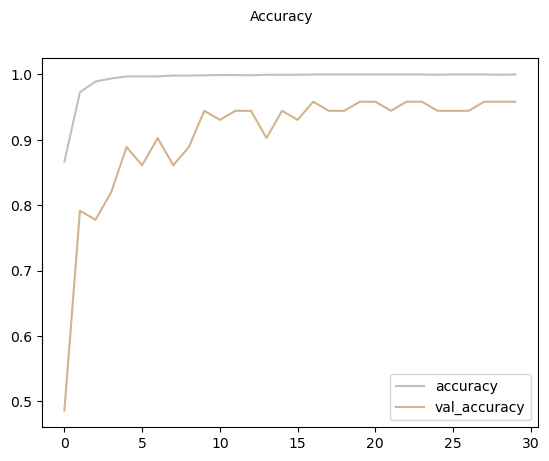

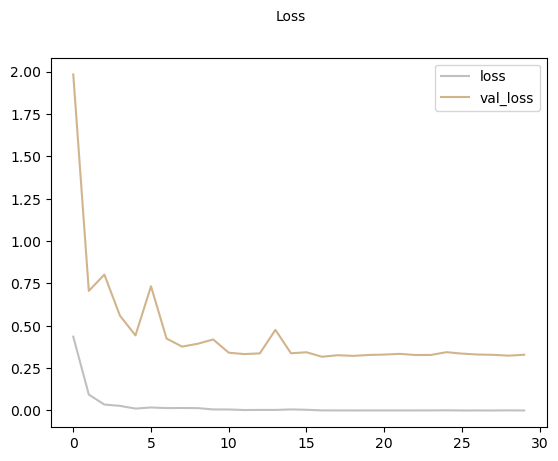

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step 
              precision    recall  f1-score   support

           0     0.8559    0.8417    0.8487       120
           1     0.7705    0.9216    0.8393        51
           2     1.0000    0.9815    0.9907        54
           3     0.9157    0.8444    0.8786        90

    accuracy                         0.8794       315
   macro avg     0.8855    0.8973    0.8893       315
weighted avg     0.8839    0.8794    0.8801       315

The Cohen's Kappa Score is: 0.8328725810505152


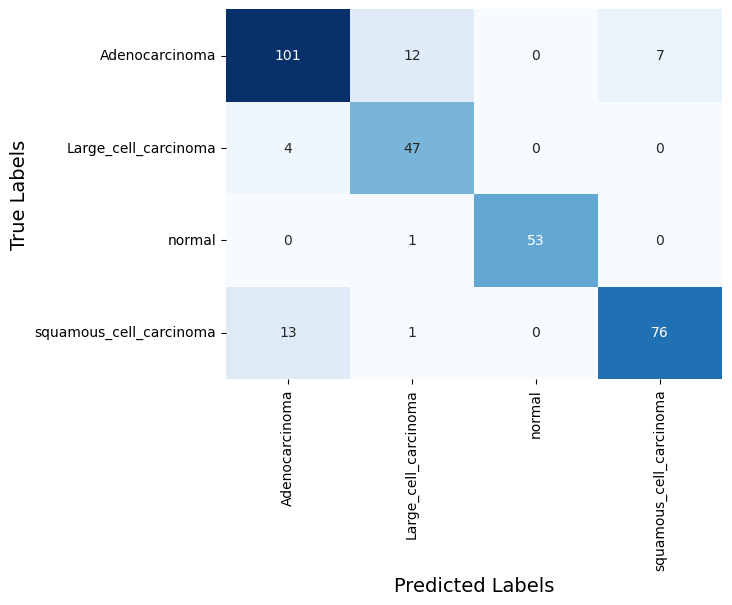

CPU times: total: 28min 22s
Wall time: 34min 56s


In [62]:
%%time

model_name = 'densenet201'
epoch_num = 30
batch = 32

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (224, 224)).numpy()
x_val = tf.image.resize(x_val, (224, 224)).numpy()
x_test = tf.image.resize(x_test, (224, 224)).numpy()


def build_model_DenseNet201():
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_DenseNet201 = build_model_DenseNet201()
model_DenseNet201.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_DenseNet201 = model_DenseNet201.fit(x_train_smt, y_train_smt, batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_DenseNet201.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_DenseNet201.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_DenseNet201.history['loss'], color='silver', label='loss')
plt.plot(history_DenseNet201.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_DenseNet201.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)

### InceptionResNetV2

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 55,918,820 (213.31 MB)

 Trainable params: 5,710,820 (21.79 MB)

 Non-trainable params: 50,208,000 (191.53 MB)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.6185 - loss: 1.1889 - val_accuracy: 0.4861 - val_loss: 1.2093 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8390 - loss: 0.4507 - val_accuracy: 0.3333 - val_loss: 2.6927 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.8991 - loss: 0.2704 - val_accuracy: 0.5417 - val_loss: 1.6039 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9285 - loss: 0.1749 - val_accuracy: 0.6111 - val_loss: 1.4038 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9561 - loss: 0.1134 - val_accuracy: 0.6528 - val_loss: 1.3183 - learning_rate: 5.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9846 - loss: 0.0714 - val_accuracy: 0.6944 - val_loss: 1.4234 - learning_rate: 5.0000e-04
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9860 - loss: 0.0422 -

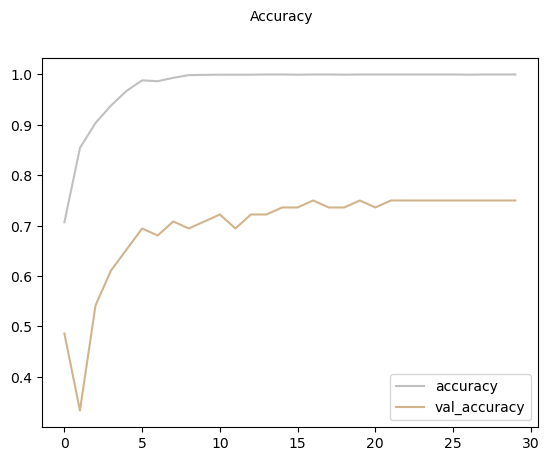

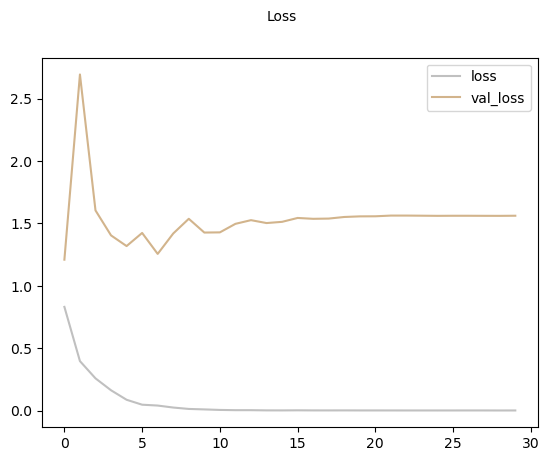

10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
              precision    recall  f1-score   support

           0     0.7113    0.5750    0.6359       120
           1     0.6111    0.8627    0.7154        51
           2     1.0000    0.9444    0.9714        54
           3     0.6000    0.6333    0.6162        90

    accuracy                         0.7016       315
   macro avg     0.7306    0.7539    0.7348       315
weighted avg     0.7128    0.7016    0.7007       315

The Cohen's Kappa Score is: 0.5921993141346114


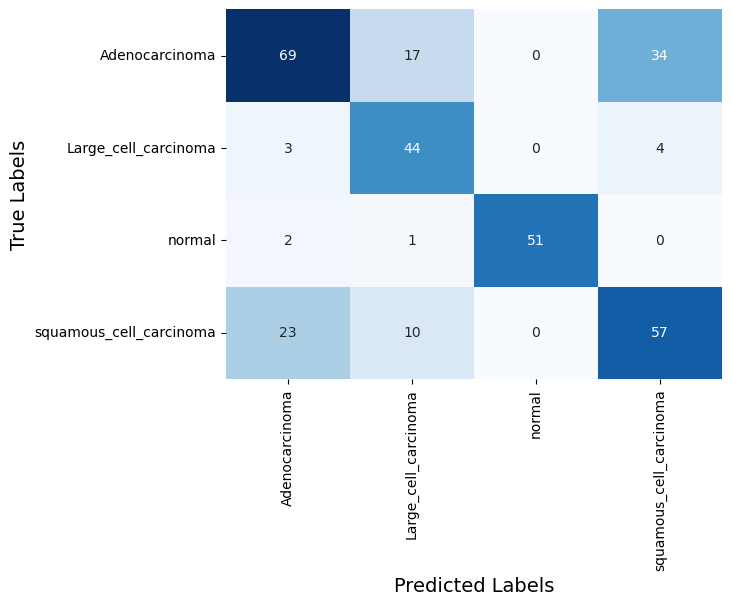

CPU times: total: 2h 27min 2s
Wall time: 1h 11min 17s


In [63]:
%%time
from tensorflow.keras.applications import InceptionResNetV2

model_name = 'inceptionresnetv2'
epoch_num = 30
batch = 32

#x_train_smt = np.repeat(x_train_smt, 3, axis=-1)
#x_val = np.expand_dims(x_val, axis=-1)
#x_val = np.repeat(x_val, 3, axis=-1)
#x_test = np.expand_dims(x_test, axis=-1)
#x_test = np.repeat(x_test, 3, axis=-1)

x_train_smt = tf.image.resize(x_train_smt, (299, 299)).numpy()
x_val = tf.image.resize(x_val, (299, 299)).numpy()
x_test = tf.image.resize(x_test, (299, 299)).numpy()


def build_model_inceptionresnetv2():
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = True
    for layer in base_model.layers[:-10]:  
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_inceptionresnetv2 = build_model_inceptionresnetv2()
model_inceptionresnetv2.summary()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history_inceptionresnetv2 = model_inceptionresnetv2.fit(x_train_smt, y_train_smt,batch_size = batch, epochs = epoch_num, validation_data = (x_val, y_val), callbacks=[lr_reducer, tensorboard_callback])

fig = plt.figure()
plt.plot(history_inceptionresnetv2.history['accuracy'], color='silver', label='accuracy')
plt.plot(history_inceptionresnetv2.history['val_accuracy'], color='tan', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=10)
plt.legend(loc="lower right")
plt.show()

fig = plt.figure()
plt.plot(history_inceptionresnetv2.history['loss'], color='silver', label='loss')
plt.plot(history_inceptionresnetv2.history['val_loss'], color='tan', label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper right")
plt.show()

y_pred = model_inceptionresnetv2.predict(x_test)

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

all_evaluation(y_test_labels, y_pred_labels, model_name, epoch_num, batch)